In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def get_elocutions(path):
    ''' 全ての台詞を取り出す処理 '''
    with open(path, encoding='utf-8') as f:
        ls = f.readlines()
        #print(ls)
        start_elocution = True
        elocutions = []
        for i in range(len(ls)):
            if start_elocution:
                elocution = [ls[i]]
                start_elocution = False
            elif ls[i]=='\n':
                elocution.append('*')
                elocutions.append("".join(elocution))
                start_elocution = True
            else:
                elocution.append(ls[i])
                start_elocution = False
    return elocutions

def return_processed(X, T, lower_bound=10):
    ''' 入力Xに対し、lower_bound < 文字の長さ < T の台詞のみ取る処理 '''
    if len(X)>T or len(X)<lower_bound:
        return None
    else:
        return X.ljust(T, '*')

def preprocessing(corpus, T=80):
    ''' corpusの台詞X毎に return_processed をかける '''
    preprocessed_corpus = []
    for X in corpus:
        X_ = return_processed(X, T)
        if X_ is not None:
            preprocessed_corpus.append(X_)
    return preprocessed_corpus

def get_corpus(path, T=80):
    ''' 前処理したコーパスを返す '''
    corpus = get_elocutions(path)
    return preprocessing(corpus, T=T)

class Generator(tf.keras.Model): # モデル設計
    def __init__(self):
        super(Generator, self).__init__()
    def sample_from(self, start_string, num_string=100):
        ''' This function is derived from the function `generate_text` in
        https://www.tensorflow.org/tutorials/text/text_generation 
        which is licensed under Apache 2.0 License. '''
        input_nums = tf.expand_dims([char2idx[c] for c in start_string], 0)
        text_generated = []
        model.reset_states()
        for i in range(num_string):
            if char2idx['*'] in input_nums.numpy():
                break
            #print(input_nums)
            z = self(input_nums)[:,-1,:]
            predicted_id = tf.random.categorical(z, num_samples=1) # このサンプリングは logit を指定して softmax からサンプリング
            text_generated.append(tf.squeeze(predicted_id).numpy())
            input_nums = predicted_id
        print(start_string+"".join([idx2char[g] for g in text_generated]))

## 4-2. 離散値データと分散表現
### シェイクスピア・データセット

> この節と次節は[tensorflowのチュートリアル](https://www.tensorflow.org/tutorials/text/text_generation?hl=ja)では同じデータを使って、以下の説明と似たことが説明されていますが、このように台詞に分けずに学習を行っています。そのようにするとGPUの処理などのコーディングがこのノートに比べ楽になりますが、このノートでは確率論的な説明を優先するためこのようなデータ形式を採用します。

tensorflowを使って、シェイクスピアのデータをダウンロードできます：

In [2]:
''' This code is derived from https://www.tensorflow.org/tutorials/text/text_generation 
    which is licensed under Apache 2.0 License. '''
path = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

`get_corpus`という関数を定義しておきました。これを使うと、以下のようにデータを「戯曲の各登場人物＋台詞」のリスト=`corpus`に分解できます：

In [3]:
corpus = get_corpus(path)
N = len(corpus)
print("台詞数 N=%d\n"%N)

for _ in range(5):
    i = np.random.randint(len(corpus))
    print(corpus[i])

台詞数 N=3461

Boatswain:
What, must our mouths be cold?
**************************************
Nurse:
She's dead, deceased, she's dead; alack the day!
************************
BRUTUS:
He's poor in no one fault, but stored with all.
************************
KING EDWARD IV:
Huntsman, what say'st thou? wilt thou go along?
****************
Clown:
Fear not thou, man, thou shalt lose nothing here.
***********************


それぞれ
- `corpus = [台詞1, 台詞2, ... ]`
- `台詞 = "xxxxx***"` (*は終わりを表すトークンで、文字数を 80 に揃えるために挿入、tensorflowの関数でも処理できますが、ここではpythonで書きました。)

のような構成になっています。`N`はこのデータに含まれる全台詞の数です。今回はこれをデータセットとします。






この中で出現する文字を重複を除き数えると

In [4]:
''' This code is derived from https://www.tensorflow.org/tutorials/text/text_generation 
    which is licensed under Apache 2.0 License. '''
chars = sorted(set(str("".join(corpus))))
print(chars); print(len(chars), "種類")

['\n', ' ', '!', '&', "'", '*', ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65 種類


のように13種類の（!, ?, ;や半角スペースや改行\nなどの）特殊文字＋アルファベット26種類 $\times$ (大文字, 小文字)＝52種類の計65種類からなる文字の集まりから構成されているのがわかります。これを

$$
\mathcal{S}_{chars} = \{\text{'$\backslash$n', ' ', '!', ..., 'A', 'B', 'C', ..., 'a', 'b', 'c', ...} \}
$$

と呼びましょう。各データはさっきも表示しましたが、改行コードなども明示的に表示させると：

In [5]:
i = np.random.randint(len(corpus))
print(list(corpus[i]))

['F', 'i', 'r', 's', 't', ' ', 'W', 'a', 't', 'c', 'h', 'm', 'a', 'n', ':', '\n', "'", 'T', 'i', 's', ' ', 't', 'h', 'e', ' ', 'L', 'o', 'r', 'd', ' ', 'H', 'a', 's', 't', 'i', 'n', 'g', 's', ',', ' ', 't', 'h', 'e', ' ', 'k', 'i', 'n', 'g', "'", 's', ' ', 'c', 'h', 'i', 'e', 'f', 'e', 's', 't', ' ', 'f', 'r', 'i', 'e', 'n', 'd', '.', '\n', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


のように、一文字ずつのリスト＝各データ、となっています。

### 離散値データの表現



#### インデックスによる表現(one-hot表現)
コンピュータ上で文字がどのように処理されているかですが、例えば [ASCII](https://ja.wikipedia.org/wiki/ASCII) と呼ばれる規格では、整数値にそれぞれの文字を割り振っています：

In [6]:
ord('A'), ord('B'), ord('C'), ord('D')

(65, 66, 67, 68)

今回はASCIIと似た戦法で、 $\mathcal{S}_{chars}$ の頭から順に 0,1,2,...,64 と呼ぶことにします：

In [7]:
''' This code is derived from https://www.tensorflow.org/tutorials/text/text_generation 
    which is licensed under Apache 2.0 License. '''
char2idx = {u:i for i, u in enumerate(chars)}
char2idx['A'], char2idx['B'], char2idx['C'], char2idx['D']

(13, 14, 15, 16)

この写像の逆変換も後から使うので作っておきます。単にインデックス入力に対応した配列として $\mathcal{S}_{chars}$ を実装すればよいだけです：

In [8]:
''' This code is derived from https://www.tensorflow.org/tutorials/text/text_generation 
    which is licensed under Apache 2.0 License. '''
idx2char = np.array(chars)
idx2char[13], idx2char[14], idx2char[15], idx2char[16]

('A', 'B', 'C', 'D')

$$
\mathcal{S}_{chars} = \{\underbrace{\text{'$\backslash$n'}}_0, \underbrace{\text{' '}}_1, \underbrace{\text{'!'}}_2, \dots, \underbrace{\text{'A'}}_{13}, \underbrace{\text{'B'}}_{14}, \underbrace{\text{'C'}}_{15}, \dots, \underbrace{\text{'a'}}_{39}, \underbrace{\text{'b'}}_{40}, \underbrace{\text{'c'}}_{41}, \dots \}
$$

以後、$\mathcal{S}_{chars}$ の要素は整数とし、 $n$ で表すことにします。すると各セリフは **数値 $n$ の集まり** 

$$
{\bf n} = [n_0, n_1, \dots, n_{T-1}]
$$

で表すことができます。

In [9]:
i = np.random.randint(len(corpus))
print(corpus[i])
print([char2idx[c] for c in corpus[i]])

BRAKENBURY:
Why looks your grace so heavily today?
*****************************
[14, 30, 13, 23, 17, 26, 14, 33, 30, 37, 10, 0, 35, 46, 63, 1, 50, 53, 53, 49, 57, 1, 63, 53, 59, 56, 1, 45, 56, 39, 41, 43, 1, 57, 53, 1, 46, 43, 39, 60, 47, 50, 63, 1, 58, 53, 42, 39, 63, 12, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


コーパスを数値化した`corpus_num`を作っておきます：

In [10]:
corpus_num = np.array([[char2idx[c] for c in n] for n in corpus])
print(corpus[0], '\n', corpus_num[0])

First Citizen:
Before we proceed any further, hear me speak.
******************* 
 [18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5]


尚、同値な表現として、**one-hot表現** というものがあります。これは

$$
n \leftrightarrow \vec{n} = [0, \dots, 0, \overbrace{1}^{n-th}, 0, \dots, 0]
$$

のように、$n$ 番目の成分のみ1であるようなベクトル表現のことを指します。

#### 2進数表現
整数をベクトルとして表現したい場合、one-hot表現だけしか無いわけではありません。例えば 10進数 $n$ を 2進数表示して、桁ごとに区切る方法も考えられます。（10進数のまま桁ごとに区切ってもベクトル化できますが、あまり使われない気がします。）

2進数表現はまた後ほど使うので、そこで詳しく説明します。

#### 分散表現
分散表現は、もっと幾何的にベクトル化する方法です。深層学習では分散表現は訓練対象である場合が多く、離散値から何らかの次元のベクトルへの埋め込み方

$$
n_t \to {\bf e}[n_t]
$$

が訓練対象になります。one-hot表現を使うと単なる線形変換で表現できます: ${\bf e}[n] = W \vec{n}= (W_{i n})_{i=1, 2, \dots}$ 

が、専用のコマンドがあります：

In [11]:
emb = tf.keras.layers.Embedding(len(chars), 2)

これで適当に初期化された２次元の分散表現を得ることができます：

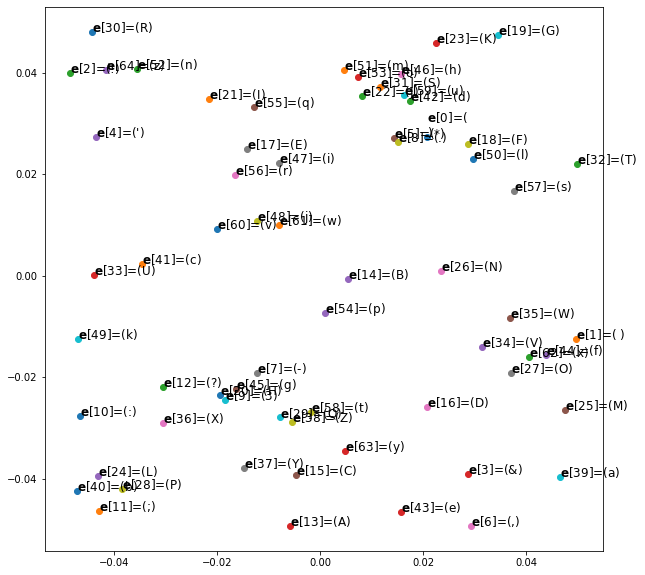

In [22]:
plt.figure(figsize=(10,10))
for nt in range(len(chars)):
    xn = emb(nt).numpy()
    plt.scatter(xn[0], xn[1])
    plt.annotate(r'${\bf e}[%d]$=(%s)'%(nt,idx2char[nt]), (xn[0], xn[1]), size=12)
plt.show()

ここでは説明のために2次元に取りましたが、もっと高次元に埋め込む場合が多いようです。以下でニューラルネットワークを構成する際、一層目にこの分散表現を使います。



### 無限の猿定理
[無限の猿定理](https://ja.wikipedia.org/wiki/無限の猿定理) という話があります。これは **猿が（ランダムに）タイプすることでシェイクスピアの作品を生成する** という「ゼロではない可能性」が無限回試行すれば起こり得る、という類の無限に関する話です。今回は規模を縮小して
- 猿がシェイクスピアのような台詞 ${\bf n}$ を書く確率

を考えてみます。これまでの理論部分で、データ生成確率 $p$ とモデル $q$ を考えていましたが、ここでも同じことで ${\bf n}=[n_0, n_1, \dots, n_{T-1}]$ を生成する確率をそれぞれ
- シェイクスピア：$p({\bf n})$
- 猿：$q_{monkey}({\bf n})$

としましょう。更に、猿はとりあえず文脈を把握しておらず、各時刻でどの文字をタイプするかは独立だとします：時刻 $t$ で1文字 $n_t$ をタイプする確率 $q_{monkey}(n_t)$ があるとして

$$
q_{monkey}({\bf n}) = \prod_{t=0}^{T-1} q_{monkey}(n_t)
$$

ということにします（猿には少々失礼な仮定かもしれませんが）。例えば1文字打つ確率がすべての文字を当確率（つまりランダム）だとすると

$$
q_{monkey}(n_t) = \frac{1}{|\mathcal{S}_{chars}|} = \frac{1}{65}
$$

です。すると、$q_{monkey}({\bf n}) = \Big( \frac{1}{65}\Big)^{T}$です。確かに厳密に言えばゼロではないですが、これはほぼ無いと言えるでしょう。一応この **猿＝完全ランダムモデル** で生成してみると：



In [12]:
T = 100
n = np.random.choice(chars, T)
print("".join([nt for nt in n]))

l
 pq
lYsLn:RmvlxPC!TFW,E;XI!'
faPkOFk YUjHquVPNg.Elvwwlorq&VDvkZJN&q;lq'WVeiC&*XdBdREd&IOL.YkBvMuWS


のようになり、シェイクスピアの戯曲を書くにはかなり遠そうなことがわかります。

### ニューラルネットワークでまねてみる
ここでは`corpus`または`corpus_num`を、一つの台詞 ${\bf n}$ をシェイクスピアが書く確率を $p({\bf n})$ として、その確率分布から独立に $N$ 個のサンプリング

$$
\text{corpus}=\mathcal{D}_N = \{ {\bf n}_1, {\bf n}_2, ..., {\bf n}_N\} \sim p({\bf n})^N
$$

だと思っているわけですが、$p({\bf n})$を真似るモデル $q({\bf n})$ を考えるには、まず $p$ がどのような構造を持つべきか考えると良さそうです。そもそも、台詞は

$$
{\bf n} = [n_0, n_1, \dots, n_{T-1}]
$$

の順に意味があるため、単に1文字出る確率 $q(n_t)$ を考えるのでは順序を捉えられそうにないのでだめでしょう。とりあえず台詞の生成は**マルコフ性**を持つ、と考えてみます。つまり

$$
q_{Markov}({\bf n}) = q(n_0)\prod_{t=0}^{T-2} q_{Markov}(n_{t+1}\mid n_t) 
$$

だと考えてみます。最初の確率 $q(n_0)$ としては例えば、台詞は役名から始まるので、大文字から始まるでしょうから、大文字26種類からランダムに取るとしましょう。ここでは$q_{Markov}(n_t\mid n_{t-1})$ に注目してください。これは条件付き確率で、**丁度ニューラルネットワーク** を導入できる形式になっています。そこで

$$
q_{Markov}(n_{t+1}\mid n_t) = q_{\theta}(n_{t+1}\mid n_t)  
$$

として、機械学習にかけてみましょう。ここでは分散表現を用いた以下のような構造を持つネットワーク

![alt](markov.jpg)

$$
\left\{ \begin{array}{ll}
{\bf e}_t={\color{red}{l_{emb}}}(n_t) & \color{red}{\text{Embedding}}
\\
{\bf h}_t = \tanh({\color{red}{l_h}}({\bf e}_t))= \tanh({\color{red}{W_h}}{\bf e}_t + {\color{red}{b_h}}) & \color{red}{\text{Dense}}
\\
{\bf z}_t = {\color{red}{l_z}}({\bf h}_t)={\color{red}{W_z}} {\bf h}_t + {\color{red}{b_z}} & \color{red}{\text{Dense}}
\\
q_{\color{red}{\theta}}(n\mid n_t) = [{\bf \color{blue}{\sigma}}({\bf z}_t)]_{n\text{-th component}} & \color{blue}{\text{Softmax}}
\end{array} \right.
$$

を使ってみます：






In [13]:
class Markov(Generator): # モデル設計
    def __init__(self, emb_dim, hidden_dim):
        super(Markov, self).__init__()
        self.l_emb= tf.keras.layers.Embedding(len(chars), emb_dim)
        self.l_h = tf.keras.layers.Dense(units=hidden_dim)
        self.l_z = tf.keras.layers.Dense(units=len(chars))
    def call(self, nt):
        e = self.l_emb(nt)
        h = tf.keras.activations.tanh(self.l_h(e))
        z = self.l_z(h)
        return z

これを使えば、自身のsoftmax出力＝確率からのサンプリングを次の文字と思って、次々に文字が生成できます：

![alt](markov2.jpg)

モデルを実際に適当な初期化の元、オブジェクトとして作って文字列を生成してみると以下のような感じです：

In [14]:
model= Markov(1,1)
model.sample_from("S", num_string=100) # * が生成されたら止まります。

SOHc*


このモデルを訓練することを考えてみましょう。
#### 汎化誤差、経験誤差
これまで通り汎化誤差は $D_{KL}(p\|q)$ として、経験誤差は

$$
L(\theta; \mathcal{D}_N) = \frac{1}{N} \sum_{i=1}^N (- \log q_\theta({\bf n}_i))
$$

ですので、1台詞サンプル ${\bf n}_i=[n_0, n_1, \dots, n_{T-1}]$ あたりの負の対数尤度を考えればそれの $N$ 平均が経験誤差となります。１サンプルあたりの負の対数尤度 $L(\theta; \{{\bf n}\})$ は

$$ - \log q_\theta({\bf n}) =  - \log q(n_0) \prod_{t=0}^{T-2}q_\theta(n_{t+1} \mid n_t) = {\color{blue}{L(\theta; \{{\bf n}\})}}
$$

です。$q(x_0)$ を後で固定した確率分布に取るので、学習パラメータ $\theta$ に依存しないため、結局 $L(\theta; \{{\bf n}\})$ を下げることが、データ ${\bf n}$ に含まれる文字の順でサンプルが生成される確率を上げるという意味になっています。$-\log$ を先に取ると積は和になりますから、$q_\theta$ が最後はsoftmax関数でモデル化していたことを思い出すと、

$$ 
{\color{blue}{L(\theta;\{ {\bf n} \})}} = - \sum_{t=0}^{T-2} \log q_\theta(n_{t+1} \mid n_t)= - \sum_{t=0}^{T-2} \Big({\bf \log} {\bf \sigma}_{softmax}({\bf z}_t )\Big)_{{n_t}\text{-th comp}} =
\sum_{t=0}^{T-2} L_{softmax}\big(n_{t+1}, {\bf \sigma}_{softmax}({\bf z}_t ) \big) 
$$

と、各時刻毎の「次の文字とその予測の間のsoftmaxクロスエントロピーを時間で足し上げたもの」が誤差関数であることがわかります。すると、$n_{T-1}$ だけ除いた文字列 ${\bf x}$ を入力信号、 $n_0$だけ除いた文字列 ${\bf y}$ を教師信号と思って、あたかも教師あり学習かのように書くことができます：

![alt](markov4.jpg)




#### データから誤差関数の実装
${\bf x}$：入力データ($n_{T-1}$ だけ除いた文字列)|${\bf y}$：教師データ($n_{0}$ だけ除いた文字列)
:---:|:---:
$[n_0, n_1, \dots, n_{T-2}]$|$[n_1, n_2, \dots, n_{T-1}]$

と見なして教師あり学習できることが分かったので、あらかじめデータを

$$
\mathcal{D}_N = \Big\{ {\bf n}^{(1)} , \quad {\bf n}^{(2)} , \quad\dots \Big\}
$$

と考えるのではなく、これと同型な

$$
\mathcal{D}_N = \Big\{ (\bf x^{(1)}, {\bf y}^{(1)}), \quad (\bf x^{(2)}, {\bf y}^{(2)}), \quad \dots \Big\}
$$

だと見なしましょう。これは以下のようなコマンドで作ることができます。

In [15]:
''' This code is derived from functions prepareing `dataset` object in 
    https://www.tensorflow.org/tutorials/text/text_generation which is licensed under Apache 2.0 License. '''
D = tf.data.Dataset.from_tensor_slices(corpus_num)
f = lambda n: (n[:-1], n[1:])
D = D.map(f)

for (x, y) in D.take(1):
    print("x=", x)
    print("y=", y)

x= tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5], shape=(79,), dtype=int64)
y= tf.Tensor(
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
 56  1 51 43  1 57 54 43 39 49  8  0  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5], shape=(79,), dtype=int64)


誤差関数は上で説明したように、各 $t$ の誤差の和

$$
L({\bf y}, model({\bf x})) = \sum_{t=0}^{T-2} L_{softmax}(n_{t+1}, \underbrace{model(n_t)}_{{\bf \sigma}({\bf z}_t)})
$$

なのですが、今のデータ形式では

In [16]:
model = Markov(emb_dim=256, hidden_dim=1024)

for (x, y) in D.take(1):
    print(tf.keras.losses.sparse_categorical_crossentropy(y, model(x), from_logits=True)) # z=model(x) は logit

tf.Tensor(
[4.194728  4.1714563 4.168303  4.1747737 4.1414847 4.1660385 4.1127143
 4.1524386 4.1641912 4.14454   4.1425385 4.1772213 4.172122  4.209669
 4.2049527 4.160085  4.2067733 4.1902823 4.2153435 4.19617   4.136768
 4.1741676 4.1675963 4.136768  4.18212   4.148957  4.144289  4.1870117
 4.1680865 4.211338  4.1836004 4.149681  4.1699243 4.2101874 4.1624427
 4.1753488 4.168456  4.1514997 4.1580896 4.1771946 4.147566  4.154824
 4.12127   4.1632433 4.1716886 4.191299  4.154824  4.21504   4.113487
 4.135355  4.202867  4.216572  4.136768  4.173488  4.1893177 4.1805544
 4.21504   4.2035832 4.1819816 4.1828103 4.1720543 4.1366353 4.1366353
 4.1366353 4.1366353 4.1366353 4.1366353 4.1366353 4.1366353 4.1366353
 4.1366353 4.1366353 4.1366353 4.1366353 4.1366353 4.1366353 4.1366353
 4.1366353 4.1366353], shape=(79,), dtype=float32)


のように、各 $t$ での $L_{softmax}$ の値を並べてベクトル化してしまいます。これの和を取る操作は、`tf.reduce_mean`を使うと良いです。（これは和ではなく平均値を取る操作ですが、同じことです）：

In [17]:
def loss_sum(y, z):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y, z, from_logits=True)) # z=model(x) は logit

In [18]:
model = Markov(emb_dim=256, hidden_dim=1024)

for (x, y) in D.take(1):
    print(loss_sum(y, model(x)))

tf.Tensor(4.1836224, shape=(), dtype=float32)


#### 学習させる
今まで同様SGDさせてみます。ミニバッチ `(X, Y)` が与えられたときのモデルの学習ステップを

In [19]:
@tf.function
def update(X, Y, model, optimizer): # 学習ステップ
    with tf.GradientTape() as tape:
        Z = model(X) 
        loss_value = loss_sum(Y, Z) 
    grads = tape.gradient(loss_value, model.trainable_variables) 
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

として、今までと同じようにSGDでパラメータ更新してみます：

In [20]:
%%time
model = Markov(emb_dim=256, hidden_dim=1024)
optimizer=tf.keras.optimizers.Adam()
batch_size = 32
epoch_size = 15

loss_averages = []
for epoch in range(epoch_size):
    batch = D.shuffle(5000).batch(batch_size, drop_remainder=True)
    loss_values = []
    for (X,Y) in batch:
        loss_value = update(X, Y, model, optimizer)
        loss_values.append(loss_value)
    loss_averages.append(np.average(loss_values))

CPU times: user 8.62 s, sys: 1.82 s, total: 10.4 s
Wall time: 5.78 s


更新後のモデルで台詞生成を試みてみます。ここで $q(n_0)$ の設定に対応するのが、はじめの文字を指定することです：

In [21]:
for _ in range(5):
    model.sample_from("A", num_string=100)

AS:
Whe bat me.
Whr, yeawayo ds t'dareloree t nothet mes t d.
What t JUMARONurcotho lliear:
I r stowi
ADY:
*
Ayod, w, w mith!
Se,-is bery dsthisepl----
NGowsesangr?
*
AMERUMathel m ll; d aknIOLUMI rr t ncy om!
*
APONGEE izepru b?
*


訓練したにもかかわらず、残念ながらうまく行かないようです。

### なぜ素朴なニューラルネットでうまく行かないか
マルコフ的なネットワークがやっていることは、例えば
- `D` の次の文字は何か？

というクイズ？のようなものです。これだと、大文字で終わる文は少なそうだから、`.`、`,`、`!`、`?`、とかが来る確率は低そうだ、位のことしかわかりません。もっと言うと、データによっては文章が **すべて** 大文字で書かれているかもしれず、その場合は当てずっぽうで当てるか、[頻度分析](https://ja.wikipedia.org/wiki/頻度分析)を使うかくらいしか考えられません。それにしても、これらの方法で文章を生成してまともな文になると考える人は居ないでしょう。

これに比べて
- `Do you enjoy studying machine` の次の文字は何か？

というクイズは格段に解きやすく、おそらく `learning?` と来そうだな、と予想できると思います。これは **文脈** から判断しているわけです。この場合でも、例えば文脈を忘れて
- `e` の次の文字は何か？

となると難しいわけですが、これらのことから文脈とは **現在の文字までの全ての文字に依存する特徴量** であると気付かされます。つまり、きちんとした文章を生成するためには

$$
q_\theta(n_{t+1} \mid n_t)
$$

ではなく

$$
q_\theta(n_{t+1} \mid [n_0, n_1, \dots, n_t])
$$

をうまく作る必要がありそうだというわけです。このように「過去の状態も考慮に入れる」ニューラルネットワークが**リカレントニューラルネットワーク(RNN)** と呼ばれるものです。

### Comments on the licensed source code used in this subsection

#### License for `Generator.sample_from()`, `path`, `chars`, `char2idx`, `idx2char`, `D`

In this notebook, the definitions of

* class method: `Generator.sample_from()`
* variables: `path`, `chars`, `char2idx`, `idx2char`, `D`

include codes derived from
https://www.tensorflow.org/tutorials/text/text_generation
which is licensed under [Apache 2.0 License](https://www.apache.org/licenses/LICENSE-2.0). For details, see their [Site Policies](https://developers.google.com/terms/site-policies)
